In [1]:
import numpy as np
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def init_layers(nn_architecture, init_params = None, seed = 99):
#     np.random.seed(seed)
    number_of_layers = len(nn_architecture)
    params_values = {}

    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        if init_params == None:
            params_values['W' + str(layer_idx)] = np.random.randn(
                layer_output_size, layer_input_size) * 0.1
            params_values['b' + str(layer_idx)] = np.random.randn(
                layer_output_size, 1) * 0.1
    if init_params != None:
        params_values = init_params
    return params_values

In [3]:
def sigmoid(v):
    return 1/(1+np.exp(-v))

def relu(v):
    return np.maximum(0,v)

In [4]:
def single_forward(v_prev, W_curr, b_curr, activation="relu"):
    u_curr = np.dot(W_curr, v_prev) + b_curr    
    if activation is "relu":
        return relu(u_curr), u_curr
    elif activation is "sigmoid":
        return sigmoid(u_curr), u_curr

In [173]:
def forward(X, params_values, nn_architecture):
    memory = {}
    v_curr = X
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        v_prev = v_curr
        
        activ_function_curr = layer["activation"]
        W_curr = params_values["W" + str(layer_idx)]
        b_curr = params_values["b" + str(layer_idx)]
        v_curr,u_curr = single_forward(v_prev, W_curr, b_curr, activ_function_curr)
        
        memory["u" + str(layer_idx)] = u_curr
        memory["v"+str(idx)] = v_prev
    memory["v" + str(layer_idx)] = v_curr    
    return v_curr, memory

In [174]:
def get_loss(Y_hat, Y):
    loss = ((Y_hat - Y)**2)/2
    return loss

In [175]:
def sigmoid_backward(dv, u):
    sig = sigmoid(u)
    return dv * sig * (1 - sig)

def relu_backward(dv, u):
    dv = np.array(dv, copy = True)
    dv[u <= 0] = 0;
    return dv;

In [176]:
def single_backward(dv_curr, W_curr, b_curr, u_curr, v_prev, activation="relu",verbose = False): 
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    du_curr = backward_activation_func(dv_curr, u_curr)
    if(verbose):
        print("du = ", du_curr)
        print("v_prev = ", v_prev)
    dW_curr = np.array([np.asarray(t)*v_prev for t in du_curr]) #/ m
    if(len(dW_curr)==1):
        dW_curr = dW_curr[0]
    db_curr = du_curr #/ m
    if(len(du_curr)== 1):
        dv_prev = du_curr * W_curr
    else:
        dv_prev = np.dot(W_curr.T, du_curr)

    return dv_prev, dW_curr, db_curr

In [177]:
def backward(Y_hat, Y, memory, params_values, nn_architecture, verbose = False):
    if(verbose):
        print("statring back propagation...\n")
    grads_values = {}
    dv_prev = Y_hat - Y  # Loss = 1/2 *(Y_hat - Y)^2
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        if(verbose):
            print("layer_idx %d: " % (layer_idx_prev+1)+ layer["activation"] )
        layer_idx_curr = layer_idx_prev + 1
        activ_function_curr = layer["activation"]
        
        dv_curr = dv_prev
        if(verbose):
            print("dv = ", dv_curr)
        v_prev = memory["v" + str(layer_idx_prev)]
        u_curr = memory["u" + str(layer_idx_curr)]
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        dv_prev, dW_curr, db_curr = single_backward(
            dv_curr, W_curr, b_curr, u_curr, v_prev, activ_function_curr, verbose)        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
        
        if(verbose):
            print("dW = ", dW_curr)
            print("db = ", db_curr)
            print("-----------------------------------------\n")
    
    return grads_values

def update(params_values, grads_values, nn_architecture, learning_rate):
    for layer_idx, layer in enumerate(nn_architecture):
        params_values["W" + str(layer_idx+1)] = params_values["W" + str(layer_idx+1)] - learning_rate * grads_values["dW" + str(layer_idx+1)]        
        params_values["b" + str(layer_idx+1)] = params_values["b" + str(layer_idx+1)] - learning_rate * grads_values["db" + str(layer_idx+1)]

    return params_values;

In [178]:
def train_SGD(X, Y, nn_architecture, epochs, learning_rate, init_params):
#     params_values = init_layers(nn_architecture, 2)
    params_values = init_params
    loss_history = []
    loss = [] 

    for i in range(epochs):
        idx = np.random.randint(len(X))
        x = [X.iloc[idx]['X1'],X.iloc[idx]['X2']]
#         print(x)
        y = Y[idx]
#         print(y)
        y_hat, history = forward(x, params_values, nn_architecture)
        l = get_loss(y_hat,y)
        loss_history.append(l)
        if((i+1)%100 == 0):
            loss_sum = 0
            for k in range(i-99,i+1):
                loss_sum += loss_history[i]
            loss.append(loss_sum[0])
        grads_values = backward(y_hat, y, history, params_values, nn_architecture)
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
    return params_values, loss, loss_history

# Question1

## 1.1

In [84]:
params = {"W1":np.ones((10,2)),"b1":np.ones(10),"W2":np.ones(10),"b2":np.ones(1)}
p = init_layers(nn_archi,init_params = params)

In [83]:
nn_archi = [
    {"input_dim": 2, "output_dim": 10, "activation": "relu"},
    {"input_dim": 10, "output_dim": 1, "activation": "sigmoid"},
]

In [85]:
X = [(1,1),(1,-1),(-1,-1)]
Y = []
for x in X:
    result,mem = forward(x,p,nn_archi)
    Y.append(result)
    print('y: %f' % result)
#     print(mem)
    print("o1-o10: ",mem['v1'])
    print("-------------------------------")

y: 1.000000
o1-o10:  [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
-------------------------------
y: 0.999983
o1-o10:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------
y: 0.731059
o1-o10:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-------------------------------


## 1.2

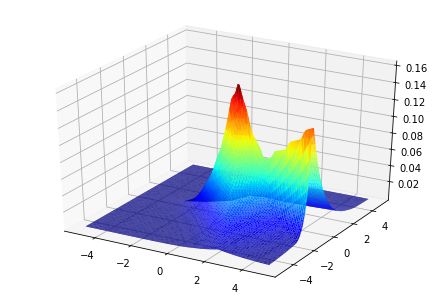

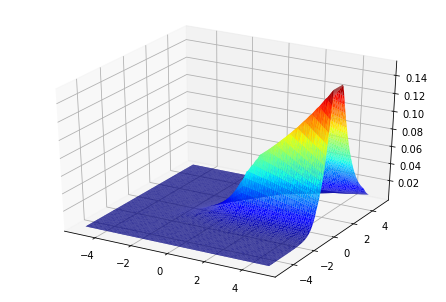

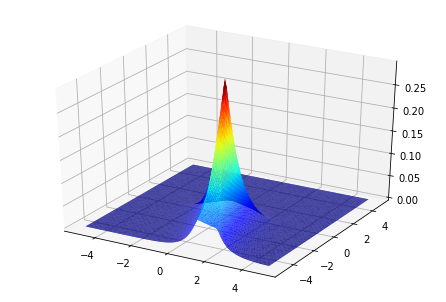

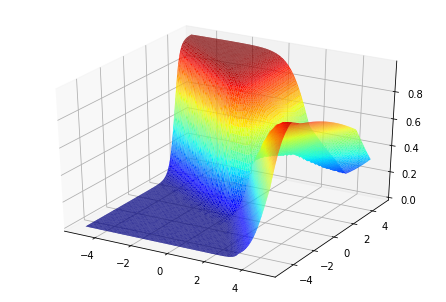

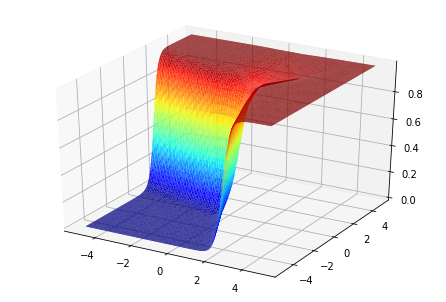

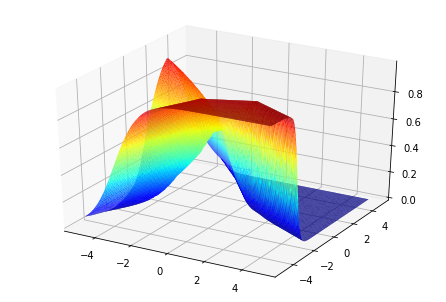

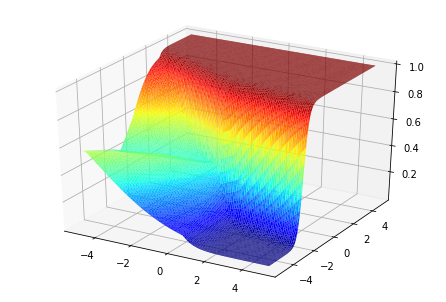

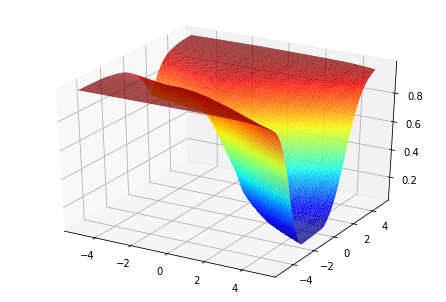

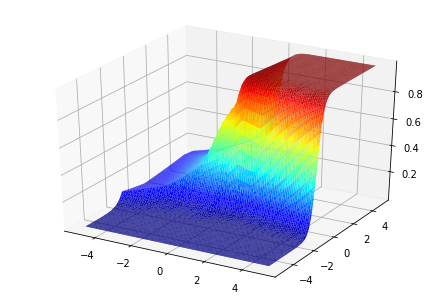

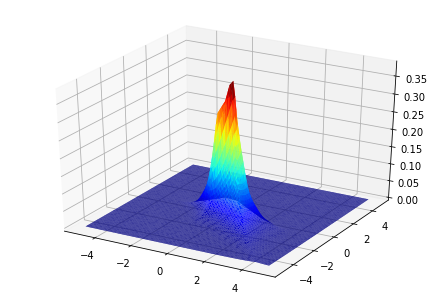

In [66]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
for hahaha in range(10):
#     np.random.seed = 123*hahaha
    params = {"W1":np.random.normal(0, 1, (10,2)),
              "b1":np.random.normal(0, 1, 10),
              "W2":np.random.normal(0, 1, 10),
              "b2":np.random.normal(0, 1, 1)}
#     print(params)
    p = init_layers(nn_archi,init_params = params)
    X = []
    Y = []
    for i in np.arange(-5,5.1,0.1):
        for j in np.arange(-5,5.1,0.1):
            X.append((i,j))
    for x in X:
        y,mem = forward(x,p,nn_archi)
        Y.append(y[0])

    fig = plt.figure()
    ax = Axes3D(fig)
    X1 = [x[0] for x in X]
    X2 = [x[1] for x in X]
    surf = ax.plot_trisurf(np.array(X1), np.array(X2), np.array(Y), cmap = cm.jet, linewidth=0.1)
    fig.savefig(str(hahaha))

## 1.3

In [86]:
nn_archi = [
    {"input_dim": 2, "output_dim": 2, "activation": "relu"},
    {"input_dim": 2, "output_dim": 2, "activation": "relu"},
    {"input_dim": 2, "output_dim": 2, "activation": "relu"},
    {"input_dim": 2, "output_dim": 2, "activation": "relu"},
    {"input_dim": 2, "output_dim": 2, "activation": "relu"},
    {"input_dim": 2, "output_dim": 1, "activation": "sigmoid"},
]

In [87]:
params = {}
for i in range(len(nn_archi)-1):
    params['W'+str(i+1)] = np.ones((2,2))
    params['b'+str(i+1)] = np.ones(2)
params['W'+str(len(nn_archi))] = np.ones((1,2))
params['b'+str(len(nn_archi))] = np.ones(1)
# params

In [88]:
p = init_layers(nn_archi,init_params = params)

In [92]:
X = [(1,1),(1,-1),(-1,-1)]
for x in X:
    result,mem = forward(x,p,nn_archi)
    print('y: %f' % result)
    for i in range(6):
#         print("u:\n",mem['u'+str(i+1)])
        print(mem['v'+str(i+1)])
    print("-------------------------------")

y: 1.000000
[3. 3.]
[7. 7.]
[15. 15.]
[31. 31.]
[63. 63.]
[1.]
-------------------------------
y: 1.000000
[1. 1.]
[3. 3.]
[7. 7.]
[15. 15.]
[31. 31.]
[1.]
-------------------------------
y: 1.000000
[0. 0.]
[1. 1.]
[3. 3.]
[7. 7.]
[15. 15.]
[1.]
-------------------------------


## 1.4

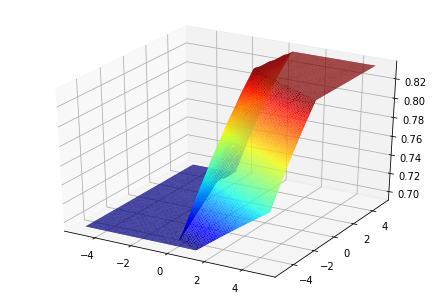

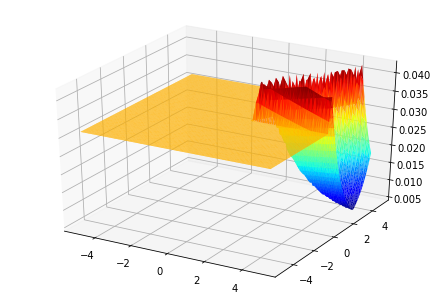

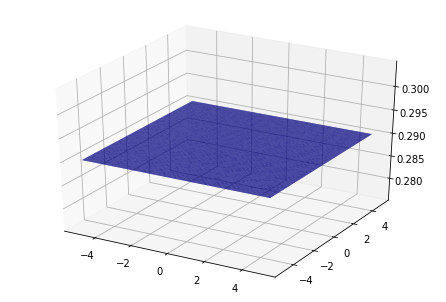

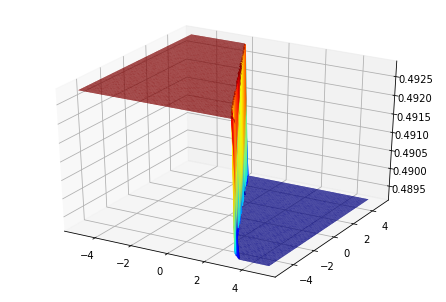

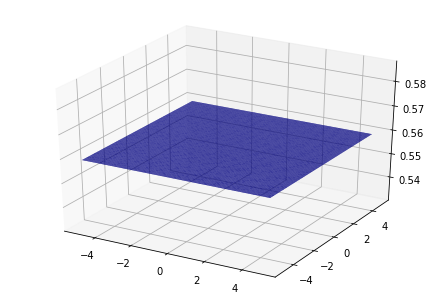

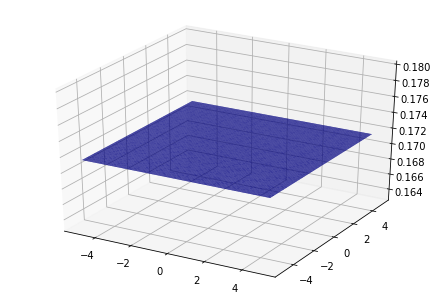

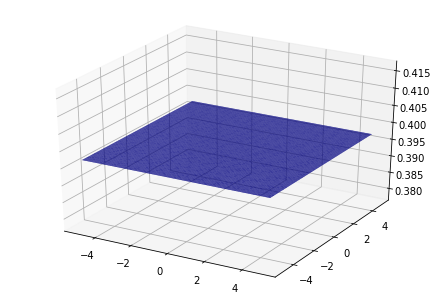

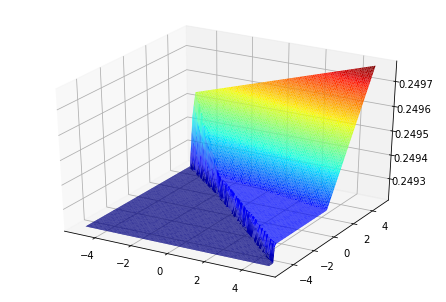

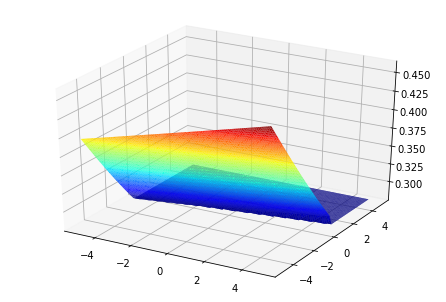

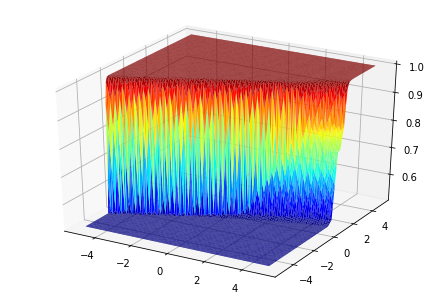

In [76]:
for hahaha in range(10):
#     np.random.seed = 123*hahaha
    params = {}
    for i in range(len(nn_archi)-1):
        params['W'+str(i+1)] = np.random.normal(0,1,(2,2))
        params['b'+str(i+1)] = np.random.normal(0,1,2)
    params['W'+str(len(nn_archi))] = np.random.normal(0,1,(1,2))
    params['b'+str(len(nn_archi))] = np.random.normal(0,1,1)
#     print(params)
    p = init_layers(nn_archi,init_params = params)
    X = []
    Y = []
    for i in np.arange(-5,5.1,0.1):
        for j in np.arange(-5,5.1,0.1):
            X.append((i,j))
    for x in X:
        y,mem = forward(x,p,nn_archi)
        Y.append(y[0])
#         print(Y)

    fig = plt.figure()
    ax = Axes3D(fig)
    X1 = [x[0] for x in X]
    X2 = [x[1] for x in X]
    surf = ax.plot_trisurf(np.array(X1), np.array(X2), np.array(Y), cmap = cm.jet, linewidth=0.1)
    fig.savefig("Q14_"+str(hahaha))

In [189]:
def print_weights(params):
    p_list = [params['b1'][0], params['W1'][0][0], params['W1'][0][1], params['b1'][1], 
              params['W1'][1][0],params['W1'][1][1], params['b2'][0], params['W2'][0],params['W2'][1]]
    p_list = [round(p,5) for p in p_list]
    print(p_list)
#     return p_list

# Question 2
## 2.1 - 2.5

In [190]:
nn_archi = [
    {"input_dim": 2, "output_dim": 2, "activation": "relu"},
    {"input_dim": 2, "output_dim": 1, "activation": "sigmoid"},
]

In [191]:
params = {"W1":np.array([[-0.2,0.3],[0.5,-0.6]]),"b1":np.array([0.1,-0.4]),"W2":np.array([-0.8,0.9]),"b2":np.array([0.7])}
p = init_layers(nn_archi,params)

print("============================================")
print("old params:")
# print(p)
old_plist= print_weights(p)

print("============================================")
y, history = forward([1,-1],p,nn_archi)
print("y = ", y[0])
print("history: ")
print(history)

print("============================================")
print("old_loss = ",get_loss(y,1))


print("============================================")
grads = backward(y, 1, history, p, nn_archi, verbose = True)

print("============================================")
print("grads")
print(grads)

print("============================================")
p_new = update(p,grads,nn_archi,0.1)
print("new params")
new_plist = print_weights(p_new)

print("============================================")
new_y, new_history = forward([1,-1],p_new,nn_archi)
print("new_loss = ",get_loss(new_y,1))

old params:
[0.1, -0.2, 0.3, -0.4, 0.5, -0.6, 0.7, -0.8, 0.9]
y =  0.7908406347869368
history: 
{'u1': array([-0.4,  0.7]), 'v0': [1, -1], 'u2': array([1.33]), 'v1': array([0. , 0.7]), 'v2': array([0.79084063])}
old_loss =  [0.02187382]
statring back propagation...

layer_idx 2: sigmoid
dv =  [-0.20915937]
du =  [-0.03459741]
v_prev =  [0.  0.7]
dW =  [-0.         -0.02421819]
db =  [-0.03459741]
-----------------------------------------

layer_idx 1: relu
dv =  [ 0.02767793 -0.03113767]
du =  [ 0.         -0.03113767]
v_prev =  [1, -1]
dW =  [[ 0.         -0.        ]
 [-0.03113767  0.03113767]]
db =  [ 0.         -0.03113767]
-----------------------------------------

grads
{'dW2': array([-0.        , -0.02421819]), 'db2': array([-0.03459741]), 'dW1': array([[ 0.        , -0.        ],
       [-0.03113767,  0.03113767]]), 'db1': array([ 0.        , -0.03113767])}
new params
[0.1, -0.2, 0.3, -0.39689, 0.50311, -0.60311, 0.70346, -0.8, 0.90242]
new_loss =  [0.02140818]


## 2.1-2.5 Validation

In [192]:
params = {"W1":np.array([[0.2,0.3],[0.5,0.6]]),"b1":np.array([0.1,0.4]),"W2":np.array([0.8,0.9]),"b2":np.array([0.7])}
p = init_layers(nn_archi,params)

print("============================================")
print("old params:")
# print(p)
old_plist= print_weights(p)

print("============================================")
y, history = forward([1,-1],p,nn_archi)
print("y = ", y[0])
print("history: ")
print(history)

print("============================================")
print("old_loss = ",get_loss(y,1))


print("============================================")
grads = backward(y, 1, history, p, nn_archi, verbose = True)

print("============================================")
print("grads")
print(grads)

print("============================================")
p_new = update(p,grads,nn_archi,0.1)
print("new params")
new_plist = print_weights(p_new)

print("============================================")
y_new, history_new = forward([1,-1],p_new,nn_archi)
print("new_loss = ",get_loss(y_new,1))

old params:
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
y =  0.7251194977898231
history: 
{'u1': array([2.77555756e-17, 3.00000000e-01]), 'v0': [1, -1], 'u2': array([0.97]), 'v1': array([2.77555756e-17, 3.00000000e-01]), 'v2': array([0.7251195])}
old_loss =  [0.03777965]
statring back propagation...

layer_idx 2: sigmoid
dv =  [-0.2748805]
du =  [-0.05478951]
v_prev =  [2.77555756e-17 3.00000000e-01]
dW =  [-1.52071452e-18 -1.64368544e-02]
db =  [-0.05478951]
-----------------------------------------

layer_idx 1: relu
dv =  [-0.04383161 -0.04931056]
du =  [-0.04383161 -0.04931056]
v_prev =  [1, -1]
dW =  [[-0.04383161  0.04383161]
 [-0.04931056  0.04931056]]
db =  [-0.04383161 -0.04931056]
-----------------------------------------

grads
{'dW2': array([-1.52071452e-18, -1.64368544e-02]), 'db2': array([-0.05478951]), 'dW1': array([[-0.04383161,  0.04383161],
       [-0.04931056,  0.04931056]]), 'db1': array([-0.04383161, -0.04931056])}
new params
[0.10438, 0.20438, 0.29562, 0.40493, 

## 2.6

In [180]:
nn_archi = [
    {"input_dim": 2, "output_dim": 2, "activation": "relu"},
    {"input_dim": 2, "output_dim": 1, "activation": "sigmoid"},
]
params = {"W1":np.array([[-0.2,0.3],[0.5,-0.6]]),
          "b1":np.array([0.1,-0.4]),
          "W2":np.array([-0.8,0.9]),
          "b2":np.array([0.7])}
p = init_layers(nn_archi,params)

In [181]:
import pandas as pd
data = pd.read_csv('data.txt', sep=" ", header=None)
data.columns = ["X1", "X2", "Y"]
X = data[['X1','X2']]
Y = data['Y']

In [182]:
params,loss,loss_history = train_SGD(X,Y,nn_archi,10000,0.1,p)

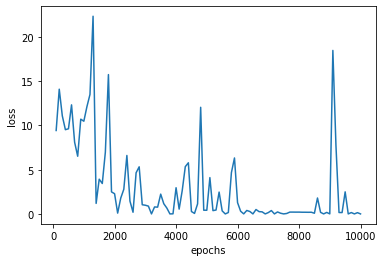

In [183]:
epochs = [i*100 for i in range(1,101)]
# epochs
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(epochs,loss)
plt.savefig('Q26.pdf')